# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator 

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 30 #experiment with the batch size

In [6]:
print(len(train_doc))
print(len(val_doc))

663
100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
x = 30
y = 120
z = 120

In [8]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized = resize(image,(y,z))
                    
                    norm = resized/127.5-1 #Normalize data
                          
                    batch_data[folder,idx,:,:,0] = (norm[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (norm[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (norm[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized = resize(image,(y,z))
                    
                    norm = resized/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (norm[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (norm[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (norm[:,:,2]) #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [10]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])


Model Method 1: 3D Convolution## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


## Model Method 1: 3D Convolution

In [11]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras import optimizers

#write your model here

model = Sequential()

model.add(Conv3D(32, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))

# 5 gestures 5 classes
model.add(Dense(5, activation = 'softmax'))

2022-11-23 11:14:33.119048: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-23 11:14:33.119115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
optimiser = optimizers.Adam(lr = 0.001) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 32)  2624      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 32)  128      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 32)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 64)    55360     
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 64)   2

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
history1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/10


2022-11-23 11:14:41.302327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 59.7684 - categorical_accuracy: 0.2926Source path =  /home/datasets/Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: val_loss improved from inf to 49.17648, saving model to model_init_2022-11-2311_14_32.373018/model-00001-59.76838-0.29261-49.17648-0.20000.h5
23/23 [==============================] - 161s 7s/step - loss: 59.7684 - categorical_accuracy: 0.2926 - val_loss: 49.1765 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 16.0042 - categorical_accuracy: 0.3043
Epoch 00002: val_loss improved from 49.17648 to 16.47742, saving model to model_init_2022-11-2311_14_32.373018/model-00002-16.00416-0.30435-16.47742-0.35000.h5
23/23 [==============================] - 28s 1s/step - loss: 16.0042 - categorical_accuracy: 0.3043 - val_loss: 16.4774 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s 

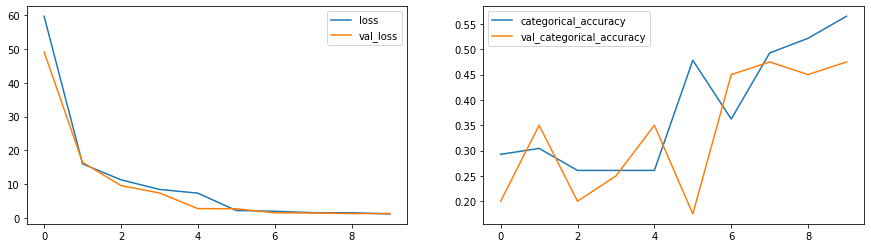

In [17]:
plot(history1)

#### The Accuracy of the model is bad on both Train and Test; It is underfitting;
#### We would need to modify model to get better results

## Model 2:
### Changing the parameters: Add one more Convolution Layer in model

In [18]:
model2 = Sequential()

model2.add(Conv3D(8, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(1, 2, 2)))

model2.add(Conv3D(32, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model2.add(Conv3D(128, kernel_size = (3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling3D(pool_size=(2, 2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))

# 5 gestures 5 classes
model2.add(Dense(5, activation = 'softmax'))

In [19]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
optimiser = optimizers.Adam(lr = 0.001) #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_3 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 30, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 30, 60, 60, 32)    6944      
                                                                 
 batch_normalization_4 (Batc  (None, 30, 60, 60, 32)  

In [23]:
history2 = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 11.1969 - categorical_accuracy: 0.3499Source path =  /home/datasets/Project_data/val ; batch size = 30
Batch:  4 Index: 30

Epoch 00001: val_loss improved from inf to 1.58761, saving model to model_init_2022-11-2311_14_32.373018/model-00001-11.19690-0.34992-1.58761-0.39000.h5
23/23 [==============================] - 166s 7s/step - loss: 11.1969 - categorical_accuracy: 0.3499 - val_loss: 1.5876 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 3.4333 - categorical_accuracy: 0.3478
Epoch 00002: val_loss did not improve from 1.58761
23/23 [==============================] - 29s 1s/step - loss: 3.4333 - categorical_accuracy: 0.3478 - val_loss: 1.7018 - val_categorical_accuracy: 0.2250 - lr: 0.0010
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 2.2362 - categorical_accuracy

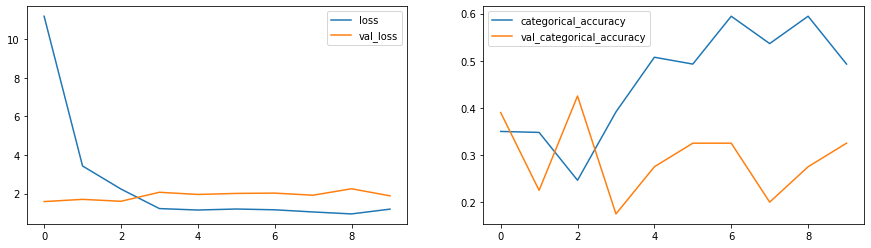

In [24]:
plot(history2)

#### The Accuracy of the model is still bad on both Train and Test; It is still underfitting;
#### We would need to modify model to get better results

## Model 3
### Changing Model Parameters further by reducing number of channels and reducing number of batches


In [26]:
model3 = Sequential()

model3.add(Conv3D(8, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(1, 2, 2)))

model3.add(Conv3D(16, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(32, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model3.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling3D(pool_size=(2, 2, 2)))
model3.add(Dropout(0.2))

model3.add(Flatten())

model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.2))

# 5 gestures 5 classes
model3.add(Dense(5, activation = 'softmax'))

In [27]:
batch_size = 10
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
optimiser = optimizers.Adam()#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_7 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 30, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_8 (Batc  (None, 30, 60, 60, 16)  

In [31]:
history3 = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 4.7944 - categorical_accuracy: 0.3363Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.52267, saving model to model_init_2022-11-2311_14_32.373018/model-00001-4.79437-0.33635-1.52267-0.39000.h5
67/67 [==============================] - 168s 3s/step - loss: 4.7944 - categorical_accuracy: 0.3363 - val_loss: 1.5227 - val_categorical_accuracy: 0.3900 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.3049 - categorical_accuracy: 0.5075
Epoch 00002: val_loss improved from 1.52267 to 1.43116, saving model to model_init_2022-11-2311_14_32.373018/model-00002-1.30492-0.50746-1.43116-0.44000.h5
67/67 [==============================] - 69s 1s/step - loss: 1.3049 - categorical_accuracy: 0.5075 - val_loss: 1.4312 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 3/10
67/6

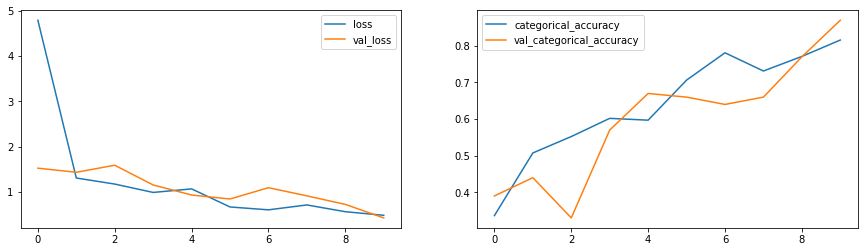

In [32]:
plot(history3)

#### The Accracy of the model is good. But Validation accuracy is more than Train ; It is overfitting.
#### Need to try different Model now

## Model 4:
### Accuracies are improving, Model looks more stable towards the end of 10 epochs
#### We can try to increase batch size or number of epochs

In [33]:
model4 = Sequential()

model4.add(Conv3D(8, kernel_size = (3,3,3),padding='same', input_shape=(30,120,120,3)))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(1, 2, 2)))

model4.add(Conv3D(16, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(32, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))

model4.add(Conv3D(64, kernel_size = (3,3,3),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation("relu"))
model4.add(MaxPooling3D(pool_size=(2, 2, 2)))
model4.add(Dropout(0.2))

model4.add(Flatten())

model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.25))

# 5 gestures 5 classes
model4.add(Dense(5, activation = 'softmax'))

In [34]:
optimiser = optimizers.Adam()#write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 30, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_12 (Conv3D)          (None, 30, 60, 60, 16)    3472      
                                                                 
 batch_normalization_12 (Bat  (None, 30, 60, 60, 16)  

In [35]:
batch_size = 10
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
num_epochs = 20
history4 = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 4.5942 - categorical_accuracy: 0.3906Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 1.75451, saving model to model_init_2022-11-2311_14_32.373018/model-00001-4.59418-0.39065-1.75451-0.29000.h5
67/67 [==============================] - 170s 3s/step - loss: 4.5942 - categorical_accuracy: 0.3906 - val_loss: 1.7545 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.5509 - categorical_accuracy: 0.4627
Epoch 00002: val_loss did not improve from 1.75451
67/67 [==============================] - 66s 997ms/step - loss: 1.5509 - categorical_accuracy: 0.4627 - val_loss: 1.7562 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 1.1684 - categorical_accuracy: 0.4975
Epoch 00003

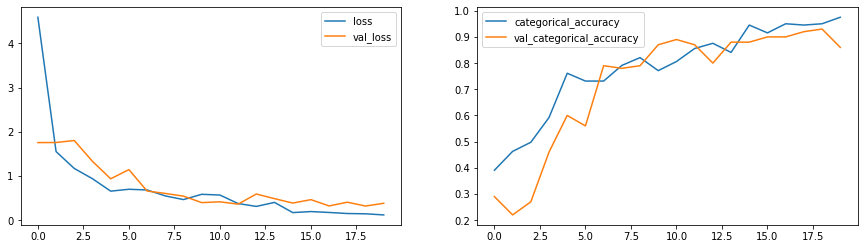

In [39]:
plot(history4)

#### The Accuracy of the model is very good. Model is looking stable but we can try something to increase Validation accuracy.
#### Need to try different Model now

## Model Method 2: CNN + RNN

In [42]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import tensorflow
import keras
from keras import optimizers
#from tensorflow.keras import optimizers

In [43]:
batch_size = 10
y = 128 # changing image crop size as mobilenet application expects size to be one of [128, 160, 192, 224]
z = 128

In [44]:
mn = keras.applications.mobilenet.MobileNet(include_top = False, weights='imagenet',input_shape=(128, 128, 3))


17235968/17225924 [==============================] - 3s 0us/step


In [45]:
model5 = Sequential()

model5.add(TimeDistributed(mn, input_shape = (30,128,128,3)))

model5.add(TimeDistributed(Flatten()))

model5.add(GRU(64,return_sequences=False))

model5.add(Dense(256))
model5.add(Activation("relu"))
model5.add(Dropout(0.2))

model5.add(Dense(5, activation = 'softmax'))

In [46]:
#optimiser = optimizers.Adam() #write your optimizer

opt = tensorflow.keras.optimizers.SGD(lr=0.001, decay=0.00001, momentum=0.8, nesterov=True)
model5.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 4, 4, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16384)        0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)                3158400   
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 activation_15 (Activation)  (None, 256)               0         
                                                                 
 dropout_9 (Dropout)         (None, 256)              

In [47]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [48]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [49]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [50]:
num_epochs = 15
history5 = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.3646 - categorical_accuracy: 0.4495Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: val_loss improved from inf to 0.96271, saving model to model_init_2022-11-2311_14_32.373018/model-00001-1.36463-0.44947-0.96271-0.72000.h5
67/67 [==============================] - 184s 3s/step - loss: 1.3646 - categorical_accuracy: 0.4495 - val_loss: 0.9627 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.8231 - categorical_accuracy: 0.7811
Epoch 00002: val_loss improved from 0.96271 to 0.78411, saving model to model_init_2022-11-2311_14_32.373018/model-00002-0.82311-0.78109-0.78411-0.74000.h5
67/67 [==============================] - 69s 1s/step - loss: 0.8231 - categorical_accuracy: 0.7811 - val_loss: 0.7841 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/15
67/6

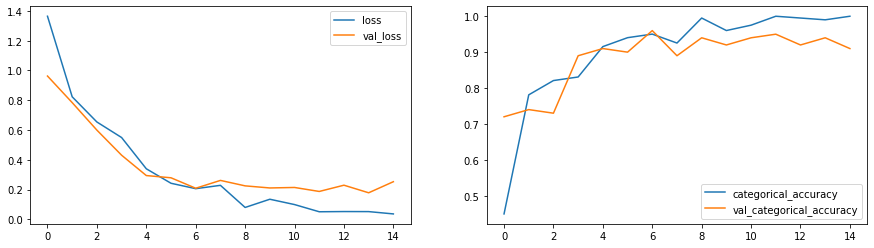

In [51]:
plot(history5)

#### The Accuracy of the model has increase to acceptable level and Model is looking stable also.

### Conclusion : We have found the final model that used transfer learning for CNN and stacked with RNN performed better.